**YOLO MODEL IMPLEMENTATION FROM SCRATCH**

We will be self-implementing the YOLO model from scratch. I have followed the tutorial by 
Aladdin Persson on youtube. 

Video Link: https://youtu.be/n9_XyCGr-MI?si=CP0nQqGeRVj46SN6

In [8]:
import torch
import torch.nn as nn
import os
import pandas as pd
from PIL import Image

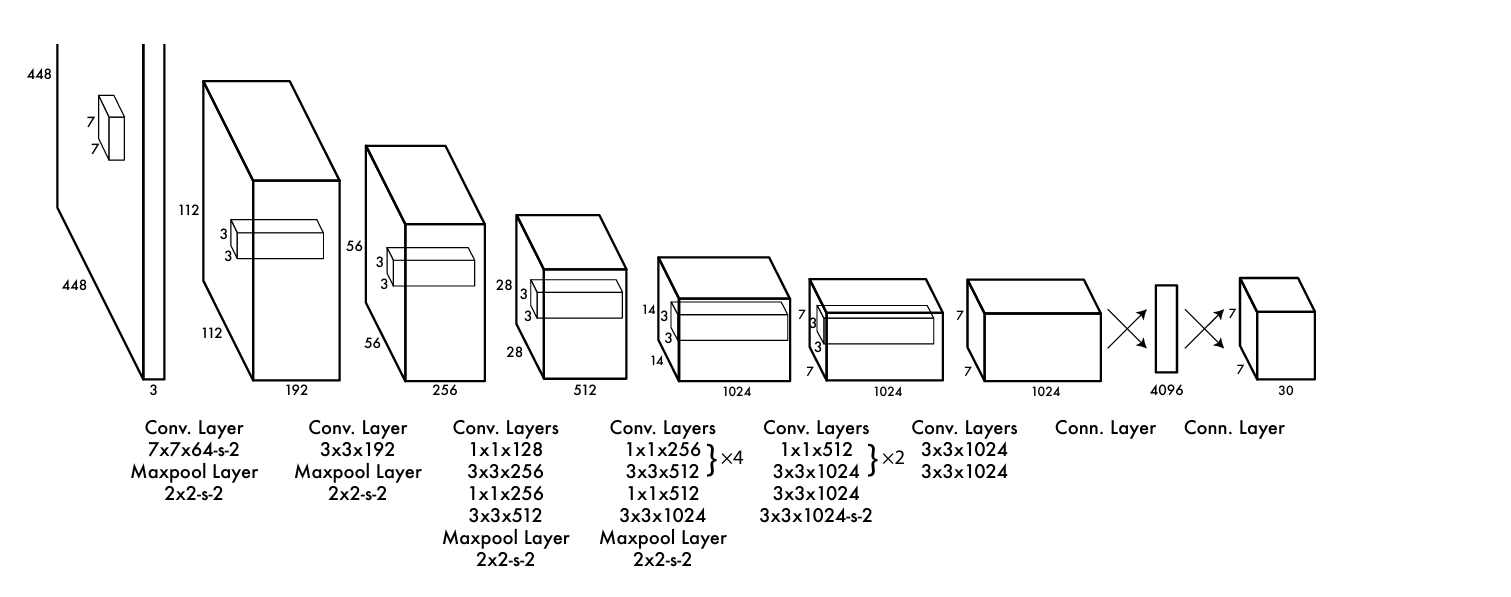

Architecture diagram of YOLO model from the paper.

Layer padding is not given and calculated using the formula [n+2p-f]\s +1

I have also implemented batch normalization for more stable learning which has not been used in the paper.

**Per grid, we have target vector of the form:**

[c1,c2,...,cn,pc1,x1,y1,w1,h1]

->c is the probability of class

->pc is probability of object

->x,y is the relative coordinates of mid-point of box

->w,h is the width and height of the bounding box

**Per grid, we have the prediction vector of the form:**

[c1,c2,...,cn,pc1,x1,y1,w1,h1,pc2,x2,y2,w2,h2,.....pcn,xn,yn,wn,hn]
     

In [4]:
class conv_block(nn.Module):
    def __init__(self,in_channels,out_channels,kernal_size,stride,padding):
        super(conv_block, self).__init__()
        self.convolution = nn.Conv2d(in_channels,out_channels,kernal_size,stride,padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.convolution(x)
        x = self.batchnorm(x)
        x = self.leakyrelu(x)
        return x

In [5]:
class yoloModel(nn.Module):
    def __init__(self, in_channels, num_grids, num_boxes, num_classes):
        super(yoloModel, self).__init__()
        self.in_channels = in_channels
        
        self.conv_layer = nn.Sequential(
            conv_block(self.in_channels, 64, 7,2,3),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            conv_block(64, 192, 3,1,1),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            conv_block(192, 128, 3,1,0),
            conv_block(128, 256, 1,1,1),
            conv_block(256, 256, 3,1,0),
            conv_block(256, 512, 1,1,1),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            conv_block(512,256,1,1,0),
            conv_block(256,512,3,1,1),
            conv_block(512,256,1,1,0),
            conv_block(256,512,3,1,1),
            conv_block(512,256,1,1,0),
            conv_block(256,512,3,1,1),
            conv_block(512,256,1,1,0),
            conv_block(256,512,3,1,1),
            conv_block(512,512,1,1,0),
            conv_block(512,1024,3,1,1),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            conv_block(1024,512,1,1,0),
            conv_block(512,1024,3,1,1),
            conv_block(1024,512,1,1,0),
            conv_block(512,1024,3,1,1),
            conv_block(1024,1024,3,1,1),
            conv_block(1024,1024,3,2,1),
            conv_block(1024,1024,3,1,1),
            conv_block(1024,1024,3,1,1),
        )
        
        self.fcs = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * num_grids * num_grids, 512), # Output size used in paper is 4096 
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(512, num_grids * num_grids *(num_classes + num_boxes * 5)),
        )
        
        self.avg_pool = nn.AdaptiveAvgPool2d((7,7)) #Convert any input to fixed output size

    def forward(self, x):
        x = self.conv_layer(x)
        print(f"Shape before adaptive pool: {x.shape}")
        x = self.avg_pool(x)
        print(f"Shape after adaptive pool: {x.shape}")
        x = self.fcs(torch.flatten(x,start_dim=1))
        return x

In [18]:
# model = yoloModel(in_channels=3 ,num_grids=7, num_boxes=2, num_classes=1)
# x = torch.randn((2, 3, 672, 672))
# print(model(x).shape)

Shape before adaptive pool: torch.Size([2, 1024, 11, 11])
Shape after adaptive pool: torch.Size([2, 1024, 7, 7])
torch.Size([2, 539])


**YOLO LOSS**

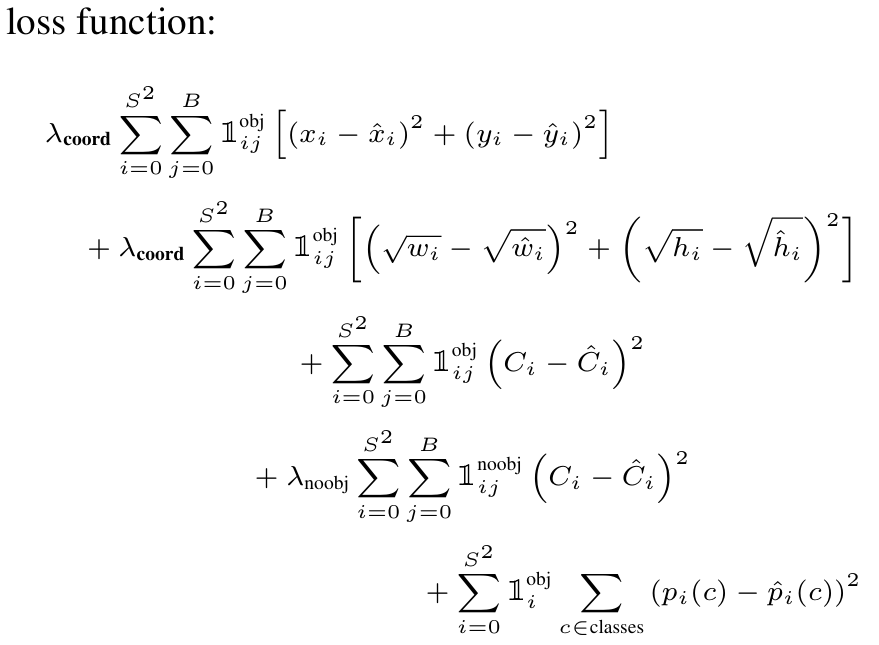

S: Number of grids

B: Number of boxes

C: Number of  classes

box_preds[...,0] -> mid point x

box_preds[...,0] -> mid point y

box_preds[...,2] -> width

box_preds[...,3] -> height

In [6]:
def intersection_over_union(box_preds, box_targets):
        box1_x1 = box_preds[..., 0] - box_preds[..., 2] / 2 
        box1_y1 = box_preds[..., 1] - box_preds[..., 3] / 2
        box1_x2 = box_preds[..., 0] + box_preds[..., 2] / 2
        box1_y2 = box_preds[..., 1] + box_preds[..., 3] / 2

        box2_x1 = box_targets[..., 0] - box_targets[..., 2] / 2
        box2_y1 = box_targets[..., 1] - box_targets[..., 3] / 2
        box2_x2 = box_targets[..., 0] + box_targets[..., 2] / 2
        box2_y2 = box_targets[..., 1] + box_targets[..., 3] / 2

        x1 = torch.max(box1_x1, box2_x1)
        y1 = torch.max(box1_y1, box2_y1)
        x2 = torch.min(box1_x2, box2_x2)
        y2 = torch.min(box1_y2, box2_y2)

        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0) # if the difference is negative, then it mean no intersection, and is set to zero.

        box1_area = box_preds[..., 2] * box_preds[..., 3]
        box2_area = box_targets[..., 2] * box_targets[..., 3]

        union = box1_area + box2_area - intersection

        return intersection / (union + 1e-6)


In [7]:
class yoloLoss(nn.Module):
    def __init__(self,S,B,C):
        super(yoloLoss,self).__init__()
        self.mse = nn.MSELoss(reduction = "sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self,x,y):
        x = x.reshape(-1,self.S,self.S,self.C + self.B *5) #(num of examples, number of grids,number of grids,number of classes + number of boxes times 5)
        y = y.reshape(-1, self.S, self.S, self.C + self.B * 5)

        obj_mask = y[..., self.C:self.C + 1]
        noobj_mask = 1 - obj_mask

        ious = []
        for b in range(self.B):
            box_preds = x[..., self.C + 5 * b + 1:self.C + 5 * b + 5]
            box_targets = y[..., self.C + 1:self.C + 5]
            iou = self.intersection_over_union(box_preds, box_targets)
            ious.append(iou.unsqueeze(0))

        ious = torch.cat(ious, dim=0)
        best_iou, best_box = torch.max(ious, dim=0)
        
        #----------------------#
        # CALCULATING BOX LOSS #
        #----------------------#
        
        box_preds = x[..., self.C + 5 * best_box + 1:self.C + 5 * best_box + 5]
        box_targets = y[..., self.C + 1:self.C + 5]

        box_preds[..., 2:4] = torch.sign(box_preds[...,2:4]) * torch.sqrt(torch.abs(box_preds[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(obj_mask * box_preds, obj_mask * box_targets)

        #-------------------------#
        # CALCULATING OBJECT LOSS #
        #-------------------------#

        obj_conf_preds = x[..., self.C + 5 * best_box:self.C + 5 * best_box + 1]
        obj_conf_targets = y[..., self.C:self.C + 1]
        obj_conf_loss = self.mse(obj_mask * obj_conf_preds, obj_mask * obj_conf_targets)

        noobj_conf_preds = x[..., self.C:self.C + 1]
        noobj_conf_loss = self.mse(noobj_mask * noobj_conf_preds, noobj_mask * obj_conf_targets)

        #------------------------#
        # CALCULATING CLASS LOSS #
        #------------------------#

        class_preds = x[..., :self.C]
        class_targets = y[..., :self.C]
        class_loss = self.mse(obj_mask * class_preds, obj_mask * class_targets)

        #------------------------#
        # CALCULATING TOTAL LOSS #
        #------------------------#

        loss = (self.lambda_coord * box_loss +
                obj_conf_loss +
                self.lambda_noobj * noobj_conf_loss +
                class_loss)

        return loss